# Hito 2 - Grupo 8
## Intregrantes
- Vicente González
- Rodrigo Iturrieta
- Pablo Jaramillo
- Cristian Lillo
- Benjamín Valenzuela

## Material

- [Repositorio](https://github.com/propublica/compas-analysis)
- [Video (hito 1)](https://drive.google.com/file/d/1TNpHXC2bTTwXfvSc1zU21SxwGIv-3yGU/view?usp=sharing)


## Introducción

Durante la última década, la sociedad moderna ha estado expuesta a un periodo de disconformidad y crisis. Múltiples protestas han ocurrido a lo largo del mundo, donde se evidencian malestares en temas de discriminación, igualdad y justicia.

Uno de estos movimientos es el de Black Lives Matter, donde la población afroamericana de Estados Unidos ha dejado claro que existe, a día de hoy, un trato desigual debido a la etnia de la persona, donde se mostró al mundo entero un sistema que los desfavorecía enormemente o directamente no esperaban nada de ellos.

La motivación del equipo nace a raíz de estas problemáticas, donde, además, desde un punto de vista de *data mining*, salta a la vista la pregunta: ¿Se puede hacer un modelo que consiga evidenciar la discriminación en una base de datos?

Particularmente, para abarcar esta problemática, se decidió dar enfoque al caso de estudio de COMPAS. En este, se encontró que el modelo predictivo **COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions) otorgaba una evaluación de riesgo mayor a personas afroamericanas que al resto. Es decir, que el modelo "discriminaba" a ciertos grupos de personas basadas en su etnia, marcándolas como potencialmente más propensos a cometer un crimen.

La idea central del proyecto es poder construir un modelo a partir de los datos de COMPAS, para poder evaluar la discriminación en la base de datos. Identificando, además los parámetros bajo los cuales COMPAS hace la discriminación.

## Exploración de datos

[Ver hito 1](hito-1_revision.html)

## Preguntas y Problemas

Dado el análisis realizado, se formularon las siguientes preguntas:

1. ¿Qué características describen mejor un factor de reincidencia?

    Como el objetivo principal de COMPAS es el de predecir la probabilidad de reincidencia de los individuos, es importante saber que el factor de reincidencia no este basado en características inherentes a las personas como lo es edad o lugar de procedencia, mientras que debería estar basada en características conductuales como lo es la gravedad de un crimen cometido.

2. ¿Existirán grupos de personas que compartan la misma tasa de reincidencia? Si existen, ¿Qué atributos componen a dichos grupos?

    Identificar grupos naturales dentro de los datos mostrará de manera más clara si existe algun tipo de sesgo con respecto a la etnia de una persona.

3. ¿Es posible predecir la etnia de una persona en base a atributos del análisis de COMPAS?

    Dependiendo de la eficaz que sea un modelo entrenado con los datos entregados por COMPAS a la hora de predecir la etnia, podemos concluir si existe realmente racismo por parte del modelo.
    
4. Con los datos que se tienen ¿Qué tan bien se puede (predecir/agrupar/clasificar) el decile_score?

    Es importante poder identficar correctamente los aspectos que influyen en el decile score, para así poder ver si en realidad los resultados se ven afectados por la etnia, o es algún otro parámetro que a su vez este estrechamente relacionado con la etnia, ya sea por temas culturales o sociales.

## Propuesta experimental
Para llevar a cabo la investigación se utilizará la siguiente metodología:

- Se realiza un preprocesamiento de datos, que consiste en sondear los datos para identificar los datos que presentan valores NA o no numericos y se eliminan y/o modifican acordemente, por ejemplo si se quiere crear un clasificador, se utilizaran valores numéricos por lo que se convierten datos tipo fecha a decimales normalizados respecto a la mínima y máxima fecha, o se crean factores ordenados para valores string categoricos, mientras que se pueden eliminar atributos con gran cantidad de valores nulos que no tienen sentido si se les asigna un valor predeterminado, como es la fecha de ocurrencia de un suceso. Un ejemplo del preprocesamiento sería: si se quisiera saber cómo afectaría el sexo, se podría transformar en valor binario dando un valor para masculino y el otro para femenino.
- Como se ve, las preguntas están muy centradas en clasificación. La idea general del proyecto es generar un modelo capaz de predecir la reincidencia de una persona, tratando de evitar que este modelo quede sesgado por la etnia. Asi como hacer un análisis del modelo COMPAS con respecto a su sesgo.
- Partiremos con el clustering, particularmente, la pregunta 4. Esta pregunta se centra en encontrar las columnas que más afectan al `decile_score` por tabla, para ello añadiremos dichos valores a cada tabla y usando el modelo KMeans y Decision Trees, nos centraremos en ir redunciendo la dimensionalidad para obtener mejores resultados.
- Para evaluar el rendimiento de los modelos usaremos el párametro F1. Comparando entre distintos modelos, obtenidos a partir de subconjuntos de columnas, nos permitira concluir que párametros tuvieron más peso dentro del modelo de COMPAS, donde una mejor predicción indica las columnas a usar por tabla para analizar el modelo.
- Una vez encontradas estas columnas filtraremos todas las tablas, para asi trabajar con los datos reducidos.
- Luego de esto, para la pregunta 2, haremos clustering de los datos con el fin de encontrar grupos naturales que se diferencien con respecto al factor de reincidencia.
- Para ello, tomaremos estas tablas filtradas y se juntaran todas en una tabla única.
- Una vez hecho esto, se quitarán las columnas relacionadas con la reincidencia, para luego aplicar una reducción de dimensionalidad a 2D usando PCA para facilitar la visualización.
- Se aplicarán modelos de clustering (KNN, Jerárquico y DBSCAN) sobre los datos.
- Para cada modelo se identificarán los *hiper-párametros* óptimos utilizando los métodos de rodilla y codo, según corresponda.
- Luego mediremos el porcentaje de reincidencia para cada clúster dentro de cada modelo, usando una división simple entre la cantidad de reincidentes dentro del clúster y las personas totales.
- Nos interesan los clústers con resultados extremos ya que con estos podemos identificar patrones en las demás características que nos permitan concluir ciertos patrones entre grupos que son "muy" reincidentes y los que no lo son.
- Para identificar dichos patrones se recurrirá a una exploración de los datos sobre los clúster, similar a la hecha para la base de datos.
- Finalmente, la última parte de la investigación corresponde a realizar los modelos de clasificación. Con los cuales seguiremos el siguiente patrón:
    - Se identificarán los atributos importantes usando matriz de correlación.
    - Se entrenaran los modelos KNeighbours y Decision Trees usando GridSearch para encontrar los mejores atributos de cada modelo. 
    - Se juzgará entorno a el parámetro f1 para determinar los mejores *hiper-parámetros*. Esto debido a que el f1 score mezcla los otros parámetros númericos, por lo que representa de mejor manera el rendimiento de un modelo.
    - Se aplicará over y sub sampling a los datos para evitar desequilibrios.
    - Dependiendo si el modelo resultante es lo suficientemente satisfactorio, se puede concluir con respecto a la pregunta.
- Particularmente, para la pregunta 1 se aplicará esto sobre la reincidencia, alterando quitando columnas. Para la pregunta 3 se hará esto usando sólo los datos que COMPAS fue capaz de generar.
- Para concluir, se analizarán los resultados obtenidos a través de las preguntas, lo que permitirá evaluar la discriminación dentro de COMPAS.



## Resultado preliminar
A continuación nos dedicaremos a responder la primera pregunta, para ello se realizó una limpieza preeliminar de los datos usando este [script](clean_tables.R) de R, de donde se exportar dichos datos a un csv y luego se cargan en Python para crear los modelos.

In [1]:
# Imports iniciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier #kNN
from sklearn.svm import SVC  # support vector machine

In [10]:
# Los datos cargados con R, los pasamos a csv, para luego leerlos con pandas
casearrest = pd.read_csv('../data/cleaned/casearrest_cl.csv')
compas_failure=pd.read_csv('../data/cleaned/compas_failure_cl.csv')
jailhistory=pd.read_csv('../data/cleaned/jailhistory_cl.csv')
people_charge=pd.read_csv('../data/original/people_charge.csv')
people=pd.read_csv('../data/cleaned/people_cl.csv')
prisonhistory=pd.read_csv('../data/cleaned/prisonhistory_cl.csv')
compas_recid=pd.read_csv('../data/cleaned/compas_recid_cl.csv')
compas_violence=pd.read_csv('../data/cleaned/compas_violence_cl.csv')

# Parámetros a utilizar en GridSearch
tuned_parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'weights': ['uniform','distance']}
score = 'f1'

Con fin de analizar la reincidencia se necesita la tabla "people" hasta la columna "is_recid".
Las columnas eliminadas y la razón de esto son las siguientes:
- age: su valor es redundante, entrega la misma info que 'dob' (date of birth).
- race: string, se omite en este caso para comprobar si su presencia influye significantemente en la capacidad predictiva del modelo.
- c_offense_date: contenía valores nulos.

Además de dejar el atributo sexo como binario.

In [11]:
dataset = people.copy()
dataset = dataset[dataset.columns[1:-9]].drop(columns=["age", "race", "c_offense_date"])
dataset['sex'] = np.where(dataset['sex']=='Male',1,0)

Formamos la matriz de correlación, donde se pueden observar las relaciones entre los distintos atributos. Con respecto a 'is_recid', se pueden distiguir como importantes a los atributos 'decile_score' y 'priors_count'.

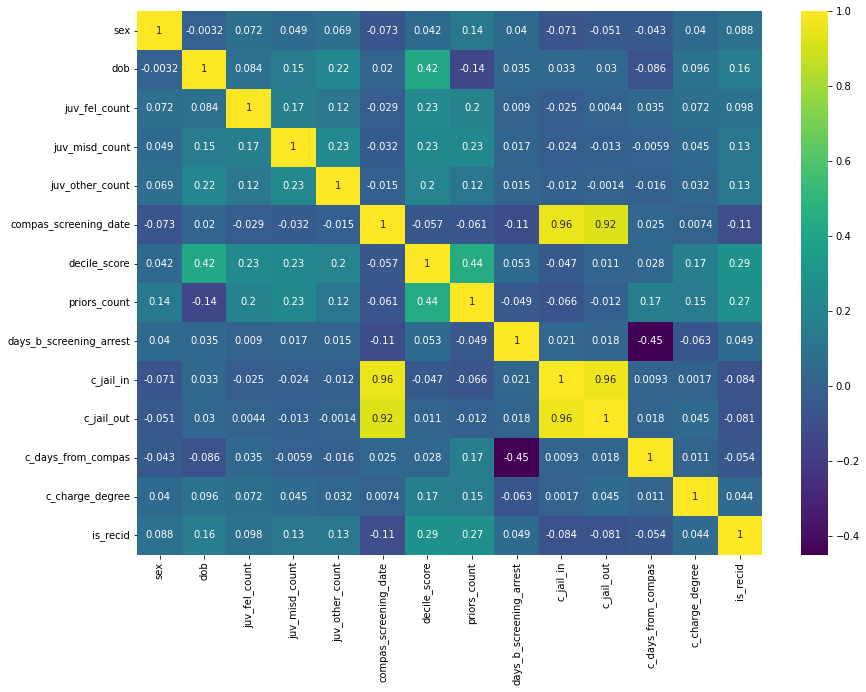

In [12]:
plt.figure(figsize=(14, 10))
sns.heatmap(dataset.corr(method='spearman'), cmap='viridis', annot=True);

Se entrenan modelos usando GridSearch y K-Neighbours, en la base de datos normalizada. Se realiza también para dataframes con SubSampling y OverSampling para después comparar sus resultados.

In [13]:
norm_dataset = (dataset -dataset.min())/(dataset.max() -dataset.min())

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['is_recid'], test_size=.30,
                                                    random_state=15, stratify=norm_dataset['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'n_neighbors': 7, 'weights': 'uniform'}
              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78      2195
         1.0       0.54      0.38      0.45      1104

    accuracy                           0.68      3299
   macro avg       0.63      0.61      0.61      3299
weighted avg       0.67      0.68      0.67      3299



In [14]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

         0.0       0.78      0.62      0.69      2195
         1.0       0.46      0.65      0.54      1104

    accuracy                           0.63      3299
   macro avg       0.62      0.63      0.61      3299
weighted avg       0.67      0.63      0.64      3299



In [15]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

         0.0       0.70      0.87      0.78      2195
         1.0       0.51      0.27      0.35      1104

    accuracy                           0.67      3299
   macro avg       0.61      0.57      0.57      3299
weighted avg       0.64      0.67      0.64      3299



Se obtuvieron los mejores parámetros para los datos originales y utilizando SubSampling y OverSampling. Sin embargo, en la matriz de correlación se pueden identificar muchos atributos poco relacionados con 'is_recid'. Se probará el omitir algunos de estos para ver si se obtienen mejores resultados.

Se omitirá primero 'days_b_screening_arrest', 'c_days_from_compas' y 'c_charge_degree', pues son los datos con la correlación menos significativa.

In [19]:
dataset2 = people.copy()
dataset2 = dataset2[dataset2.columns[1:-9]].drop(columns=["age", "race", "c_offense_date", "c_charge_degree", "c_days_from_compas", "days_b_screening_arrest"])
dataset2["sex"] = np.where(dataset2["sex"]=='Male',1,0)

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset2, dataset2['is_recid'], test_size=.30,
                                                    random_state=15, stratify=dataset2['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'n_neighbors': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2195
           1       0.34      0.34      0.34      1104

    accuracy                           0.56      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.56      0.56      0.56      3299



In [20]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 5, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.69      0.51      0.59      2195
           1       0.36      0.54      0.43      1104

    accuracy                           0.52      3299
   macro avg       0.52      0.53      0.51      3299
weighted avg       0.58      0.52      0.53      3299



In [21]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.67      0.84      0.74      2195
           1       0.35      0.17      0.23      1104

    accuracy                           0.62      3299
   macro avg       0.51      0.50      0.49      3299
weighted avg       0.56      0.62      0.57      3299



Ahora se omitirán todos los atributos cuya correlación con 'is_recid' esté entre $-0.1$ y $0.1$.

In [22]:
dataset3 = people.copy()
dataset3 = dataset3[dataset3.columns[1:-9]].drop(columns=["age", "race", "sex", "c_charge_degree", "c_offense_date", "c_days_from_compas", "days_b_screening_arrest", "c_jail_out", "c_jail_in", "juv_fel_count"])

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset3, dataset3['is_recid'], test_size=.30,
                                                    random_state=15, stratify=dataset3['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2195
           1       0.35      0.34      0.34      1104

    accuracy                           0.57      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.56      0.57      0.57      3299



In [23]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.70      0.53      0.60      2195
           1       0.37      0.55      0.44      1104

    accuracy                           0.54      3299
   macro avg       0.54      0.54      0.52      3299
weighted avg       0.59      0.54      0.55      3299



In [24]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2195
           1       0.35      0.17      0.23      1104

    accuracy                           0.62      3299
   macro avg       0.51      0.51      0.49      3299
weighted avg       0.56      0.62      0.57      3299



De momento, se obtuvo la Accuracy más alta de $0.68$ utilizando todos los parámetros de la tabla (a excepción de race) y sin realizar ni SubSampling ni OverSampling. Estos valores aún no son suficientes para ayudar a dar una respueta concisa la pregunta propuesta.

Se repetiran los entrenamientos, pero utilizando el atributo 'race'. Al ser un string se pasará a binario, donde si es igual a 'African-American' se le asignara un $1$ y, en caso contrario, un $0$.

Notemos que la correlación entre 'is_recid' y 'race' es bastante menor, con un valor de solo $0.13$.

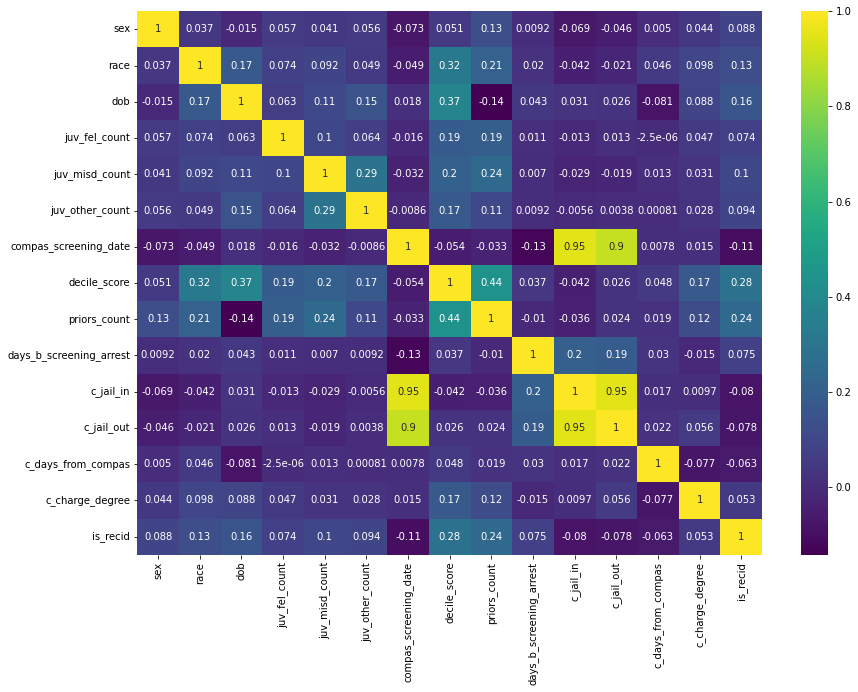

In [27]:
peoplemejor=people.copy()
peoplemejor['race'] = np.where(peoplemejor['race']=='African-American',1,0)
peoplemejor['sex'] = np.where(peoplemejor['sex']=='Male',1,0)
peoplemejor = peoplemejor[peoplemejor.columns[1:-9]].drop(columns=["age", "c_offense_date"])
plt.figure(figsize=(14, 10))
sns.heatmap(peoplemejor.corr(), cmap='viridis', annot=True);

Entrenar modelos usando GridSearch, etnia y sexo binarios.

In [28]:
##########################  KNeighbors con race  ##########################
###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor, peoplemejor['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2195
           1       0.35      0.36      0.35      1104

    accuracy                           0.57      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.57      0.57      0.57      3299



In [29]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.71      0.53      0.60      2195
           1       0.37      0.56      0.45      1104

    accuracy                           0.54      3299
   macro avg       0.54      0.55      0.53      3299
weighted avg       0.60      0.54      0.55      3299



In [30]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.84      0.74      2195
           1       0.34      0.17      0.22      1104

    accuracy                           0.61      3299
   macro avg       0.50      0.50      0.48      3299
weighted avg       0.56      0.61      0.57      3299



Se repite lo anterior, omitiendo los mismos atributos poco significativos del caso anterior 'days_b_screening_arrest', 'c_days_from_compas' y 'c_charge_degree'.

In [31]:
peoplemejor2=people.copy()
peoplemejor2['race'] = np.where(peoplemejor2['race']=='African-American',1,0)
peoplemejor2['sex'] = np.where(peoplemejor2['sex']=='Male',1,0)
peoplemejor2 = peoplemejor2[peoplemejor2.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date", "days_b_screening_arrest", "c_days_from_compas"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor2, peoplemejor2['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor2['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      2195
           1       0.34      0.34      0.34      1104

    accuracy                           0.56      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.56      0.56      0.56      3299



In [32]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.70      0.55      0.62      2195
           1       0.37      0.54      0.44      1104

    accuracy                           0.54      3299
   macro avg       0.54      0.54      0.53      3299
weighted avg       0.59      0.54      0.56      3299



In [34]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2195
           1       0.36      0.17      0.23      1104

    accuracy                           0.62      3299
   macro avg       0.52      0.51      0.49      3299
weighted avg       0.57      0.62      0.58      3299



Se realiza el mismo entrenamiento anterior, pero esta vez se omitiran los atributos menos significativos en la segunda matriz de correlación, 'juv_fel_count', 'c_days_from_compas' y 'c_charge_degree'.

In [35]:
peoplemejor21=people.copy()
peoplemejor21['race'] = np.where(peoplemejor21['race']=='African-American',1,0)
peoplemejor21['sex'] = np.where(peoplemejor21['sex']=='Male',1,0)
peoplemejor21 = peoplemejor21[peoplemejor21.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date", "juv_fel_count", "c_days_from_compas"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor21, peoplemejor21['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor21['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.67      0.68      0.67      2195
           1       0.35      0.34      0.34      1104

    accuracy                           0.56      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.56      0.56      0.56      3299



In [36]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 6, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.69      0.53      0.60      2195
           1       0.36      0.53      0.43      1104

    accuracy                           0.53      3299
   macro avg       0.52      0.53      0.51      3299
weighted avg       0.58      0.53      0.54      3299



In [38]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      2195
           1       0.32      0.15      0.20      1104

    accuracy                           0.61      3299
   macro avg       0.49      0.49      0.47      3299
weighted avg       0.55      0.61      0.56      3299



Se repite el entrenamiento, omitiendo todos los atributos cuya correlación con 'is_recid' esté entre $-0.1$ y $0.1$.

In [39]:
peoplemejor3=people.copy()
peoplemejor3['race'] = np.where(peoplemejor3['race']=='African-American',1,0)
#peoplemejor3['sex'] = np.where(peoplemejor3['sex']=='Male',1,0)
peoplemejor3 = peoplemejor3[peoplemejor3.columns[1:-9]].drop(columns=["age", "sex", "c_charge_degree", "c_offense_date", "c_days_from_compas", "days_b_screening_arrest", "c_jail_out", "c_jail_in", "juv_fel_count", "juv_other_count"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor3, peoplemejor3['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor3['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'n_neighbors': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      2195
           1       0.35      0.34      0.34      1104

    accuracy                           0.57      3299
   macro avg       0.51      0.51      0.51      3299
weighted avg       0.56      0.57      0.57      3299



In [40]:
### modelo subsampling
clf_sub = GridSearchCV(KNeighborsClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'n_neighbors': 9, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.70      0.54      0.61      2195
           1       0.37      0.55      0.45      1104

    accuracy                           0.54      3299
   macro avg       0.54      0.54      0.53      3299
weighted avg       0.59      0.54      0.55      3299



In [41]:
### modelo oversampling
clf_over = GridSearchCV(KNeighborsClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'n_neighbors': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.67      0.85      0.75      2195
           1       0.35      0.16      0.22      1104

    accuracy                           0.62      3299
   macro avg       0.51      0.50      0.48      3299
weighted avg       0.56      0.62      0.57      3299



Incluyendo el atributo 'race' no se alcanza una Accuracy mayor o igual a la alcanzada anteriormente $0.69$.

Se repetiran todos los entrenamientos anteriores, utilizando Oversampling, Subsampling y tomando en cuenta o no al atributo 'race'. En este caso se utilizará un clasificador de **Decision Tree**, con el fin de abordar más posibilidades y así seleccionar el mejor resultado entre ambos clasificadores.

In [42]:
dataset = people.copy()
dataset = dataset[dataset.columns[1:-9]].drop(columns=["age", "race", "c_offense_date"])
dataset['sex'] = np.where(dataset['sex']=='Male',1,0)

# Parámetros a utilizar en GridSearch-DecisionTree
tuned_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'criterion': ['gini','entropy']}

Se entrenan modelos usando GridSearch, en la base de datos normalizada. Se realiza también para dataframes con SubSampling y OverSampling.

In [43]:
norm_dataset = (dataset -dataset.min())/(dataset.max() -dataset.min())

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(norm_dataset, norm_dataset['is_recid'], test_size=.30,
                                                    random_state=15, stratify=norm_dataset['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

         0.0       0.76      0.78      0.77      2195
         1.0       0.55      0.52      0.53      1104

    accuracy                           0.70      3299
   macro avg       0.66      0.65      0.65      3299
weighted avg       0.69      0.70      0.69      3299



In [44]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

         0.0       0.82      0.43      0.57      2195
         1.0       0.42      0.80      0.55      1104

    accuracy                           0.56      3299
   macro avg       0.62      0.62      0.56      3299
weighted avg       0.68      0.56      0.56      3299



In [45]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80      2195
         1.0       0.59      0.13      0.22      1104

    accuracy                           0.68      3299
   macro avg       0.64      0.54      0.51      3299
weighted avg       0.66      0.68      0.60      3299



Se realiza otro entrenamiento, omitiendo los parámetros menos significativos 'days_b_screening_arrest', 'c_days_from_compas' y 'c_charge_degree'.

In [46]:
dataset2 = people.copy()
dataset2 = dataset2[dataset2.columns[1:-9]].drop(columns=["age", "race", "c_charge_degree", "c_offense_date", "c_days_from_compas", "days_b_screening_arrest"])
dataset2["sex"] = np.where(dataset2["sex"]=='Male',1,0)

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset2, dataset2['is_recid'], test_size=.30,
                                                    random_state=15, stratify=dataset2['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 7}
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      2195
           1       0.61      0.37      0.46      1104

    accuracy                           0.71      3299
   macro avg       0.67      0.63      0.63      3299
weighted avg       0.69      0.71      0.69      3299



In [47]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.82      0.43      0.57      2195
           1       0.42      0.80      0.55      1104

    accuracy                           0.56      3299
   macro avg       0.62      0.62      0.56      3299
weighted avg       0.68      0.56      0.56      3299



In [48]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.70      0.94      0.80      2195
           1       0.62      0.20      0.31      1104

    accuracy                           0.69      3299
   macro avg       0.66      0.57      0.55      3299
weighted avg       0.67      0.69      0.64      3299



Ahora se omitirán todos los atributos cuya correlación con 'is_recid' esté entre $-0.1$ y $0.1$.

In [49]:
dataset3 = people.copy()
dataset3 = dataset3[dataset3.columns[1:-9]].drop(columns=["age", "race", "sex", "c_charge_degree", "c_offense_date", "c_days_from_compas", "days_b_screening_arrest", "c_jail_out", "c_jail_in", "juv_fel_count"])

###separamos valores
data_train, data_test, y_train, y_test = train_test_split(dataset3, dataset3['is_recid'], test_size=.30,
                                                    random_state=15, stratify=dataset3['is_recid'])
##subsampleamos
data_train = data_train.reset_index(drop=True)
idx = np.random.choice(data_train.loc[data_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = data_train.drop(data_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(data_train[data_train['is_recid'] == 1].index, size=2545)
data_oversampled = data_train.drop(data_train.iloc[idx].index)

### dejamos los datos para trabajar
y_test = data_test.is_recid
X_test = data_test.drop(columns=['is_recid'])
y_orig =data_train.is_recid
X_orig = data_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORIG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORIG Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 13}
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      2195
           1       0.58      0.37      0.45      1104

    accuracy                           0.70      3299
   macro avg       0.66      0.62      0.62      3299
weighted avg       0.68      0.70      0.68      3299



In [50]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                   param_grid=tuned_parameters,
                   cv=5,
                   scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.83      0.47      0.60      2195
           1       0.43      0.80      0.56      1104

    accuracy                           0.58      3299
   macro avg       0.63      0.63      0.58      3299
weighted avg       0.69      0.58      0.58      3299



In [51]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2195
           1       0.60      0.14      0.23      1104

    accuracy                           0.68      3299
   macro avg       0.64      0.55      0.51      3299
weighted avg       0.66      0.68      0.61      3299



Con el cambio de clasificador se notan dos casos sobresalientes. Ambos no realizan SubSampling ni OverSampling. Se obtuvo un Accuracy de $0.70$ al utilizar todos los atributos (salvo de 'race') y $0.71$ dejando de lado los tres atributos menos significativos.

Se repetiran los entrenamientos, pero utilizando el atributo 'race'.

In [52]:
peoplemejor=people.copy()
peoplemejor['race'] = np.where(peoplemejor['race']=='African-American',1,0)
peoplemejor['sex'] = np.where(peoplemejor['sex']=='Male',1,0)
peoplemejor = peoplemejor[peoplemejor.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date"])

Entrenar modelos usando GridSearch, 'race' y sexo binarios.

In [53]:
##########################  KNeighbors con race  ##########################
###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor, peoplemejor['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2195
           1       0.55      0.52      0.53      1104

    accuracy                           0.70      3299
   macro avg       0.66      0.65      0.65      3299
weighted avg       0.69      0.70      0.69      3299



In [54]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      2195
           1       0.52      0.65      0.58      1104

    accuracy                           0.68      3299
   macro avg       0.66      0.67      0.66      3299
weighted avg       0.70      0.68      0.69      3299



In [55]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 12}
              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2195
           1       0.59      0.08      0.14      1104

    accuracy                           0.67      3299
   macro avg       0.63      0.53      0.47      3299
weighted avg       0.65      0.67      0.58      3299



Se repite lo anterior, omitiendo los atributos poco significativos 'days_b_screening_arrest', 'c_days_from_compas' y 'c_charge_degree'.

In [56]:
peoplemejor2=people.copy()
peoplemejor2['race'] = np.where(peoplemejor2['race']=='African-American',1,0)
peoplemejor2['sex'] = np.where(peoplemejor2['sex']=='Male',1,0)
peoplemejor2 = peoplemejor2[peoplemejor2.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date", "days_b_screening_arrest", "c_days_from_compas"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor2, peoplemejor2['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor2['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 6}
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      2195
           1       0.61      0.37      0.46      1104

    accuracy                           0.71      3299
   macro avg       0.67      0.63      0.63      3299
weighted avg       0.69      0.71      0.69      3299



In [57]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2195
           1       0.50      0.66      0.57      1104

    accuracy                           0.67      3299
   macro avg       0.65      0.67      0.65      3299
weighted avg       0.70      0.67      0.67      3299



In [58]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.69      0.95      0.80      2195
           1       0.57      0.13      0.22      1104

    accuracy                           0.68      3299
   macro avg       0.63      0.54      0.51      3299
weighted avg       0.65      0.68      0.60      3299



Se realiza el mismo entrenamiento anterior, pero esta vez se omitiran los atributos menos significativos en la segunda matriz de correlación, 'juv_fel_count', 'c_days_from_compas' y 'c_charge_degree'.

In [59]:
peoplemejor21=people.copy()
peoplemejor21['race'] = np.where(peoplemejor21['race']=='African-American',1,0)
peoplemejor21['sex'] = np.where(peoplemejor21['sex']=='Male',1,0)
peoplemejor21 = peoplemejor21[peoplemejor21.columns[1:-9]].drop(columns=["age", "c_charge_degree","c_offense_date", "juv_fel_count", "c_days_from_compas"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor21, peoplemejor21['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor21['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2195
           1       0.56      0.46      0.50      1104

    accuracy                           0.70      3299
   macro avg       0.65      0.64      0.64      3299
weighted avg       0.69      0.70      0.69      3299



In [60]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.80      0.54      0.65      2195
           1       0.44      0.73      0.55      1104

    accuracy                           0.60      3299
   macro avg       0.62      0.63      0.60      3299
weighted avg       0.68      0.60      0.61      3299



In [61]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15}
              precision    recall  f1-score   support

           0       0.68      0.95      0.79      2195
           1       0.55      0.13      0.21      1104

    accuracy                           0.67      3299
   macro avg       0.62      0.54      0.50      3299
weighted avg       0.64      0.67      0.60      3299



Se repite el entrenamiento, omitiendo todos los atributos cuya correlación con 'is_recid' esté entre $-0.1$ y $0.1$.

In [62]:
peoplemejor3=people.copy()
peoplemejor3['race'] = np.where(peoplemejor3['race']=='African-American',1,0)
peoplemejor3['sex'] = np.where(peoplemejor3['sex']=='Male',1,0)
peoplemejor3 = peoplemejor3[peoplemejor3.columns[1:-9]].drop(columns=["age", "sex", "c_charge_degree", "c_offense_date", "c_days_from_compas", "days_b_screening_arrest", "c_jail_out", "c_jail_in", "juv_fel_count"])

###separamos valores
X_train, X_test, y_train, y_test = train_test_split(peoplemejor3, peoplemejor3['is_recid'], test_size=.30,
                                                          random_state=15, stratify=peoplemejor3['is_recid'])
##subsampleamos
X_train = X_train.reset_index(drop=True)
idx = np.random.choice(X_train.loc[X_train.is_recid == 0].index, size=2545, replace=False)
data_subsampled = X_train.drop(X_train.iloc[idx].index)
##Oversampleamos
idx = np.random.choice(X_train[X_train['is_recid'] == 1].index, size=2545)
data_oversampled = X_train.drop(X_train.iloc[idx].index)
### dejamos los datos para trabajar
y_test = X_test.is_recid
X_test = X_test.drop(columns=['is_recid'])
y_orig =X_train.is_recid
X_orig = X_train.drop(columns=['is_recid'])
y_subs=data_subsampled.is_recid
X_subs=data_subsampled.drop(columns=['is_recid'])
y_over=data_oversampled.is_recid
X_over=data_oversampled.drop(columns=['is_recid'])

### modelo del original
clf_org = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" ORG Mejor combinación de parámetros:")
clf_org.fit(X_orig,y_orig)
print(clf_org.best_params_)

y_pred = clf_org.predict(X_test)

print(classification_report(y_test, y_pred))

 ORG Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 6}
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      2195
           1       0.57      0.38      0.45      1104

    accuracy                           0.69      3299
   macro avg       0.65      0.62      0.62      3299
weighted avg       0.68      0.69      0.68      3299



In [63]:
### modelo subsampling
clf_sub = GridSearchCV(DecisionTreeClassifier(),
                       param_grid=tuned_parameters,
                       cv=5,
                       scoring=score)
print(" SUB Mejor combinación de parámetros:")
clf_sub.fit(X_subs,y_subs)
print(clf_sub.best_params_)

y_pred = clf_sub.predict(X_test)

print(classification_report(y_test, y_pred))

 SUB Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.80      0.54      0.65      2195
           1       0.44      0.73      0.55      1104

    accuracy                           0.60      3299
   macro avg       0.62      0.63      0.60      3299
weighted avg       0.68      0.60      0.61      3299



In [64]:
### modelo oversampling
clf_over = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=tuned_parameters,
                        cv=5,
                        scoring=score)
print(" OVER Mejor combinación de parámetros:")
clf_over.fit(X_over,y_over)
print(clf_over.best_params_)

y_pred = clf_over.predict(X_test)

print(classification_report(y_test, y_pred))

 OVER Mejor combinación de parámetros:
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 4}
              precision    recall  f1-score   support

           0       0.69      0.96      0.80      2195
           1       0.60      0.13      0.21      1104

    accuracy                           0.68      3299
   macro avg       0.64      0.54      0.51      3299
weighted avg       0.66      0.68      0.60      3299



Al incluir el atributo 'race' y utilizar Decision Trees no se obtuvieron resultados mejores. De hecho, los casos sobresalientes mencionados anteriormente se repiten.
La mejor Accuracy fue de $0.71$, la cual se obtuvo utilizando Decision Tree y dejando de lado los atributos 'days_b_screening_arrest', 'c_days_from_compas' y 'c_charge_degree'.

Volviendo a la pregunta propuesta: **¿Qué características describen mejor un factor de reincidencia?**
Con los entrenamientos realizados *si se podría* dar una respuesta a esta pregunta. Se puede decir que estos factores son aquellos atributos que estuvieron presentes en todos los entrenamientos, o aquellos presentes en el entrenamiento con mejor Accuracy. Sin embargo esto no sería lo más correcto.

Recordar que solo se obtuvo una Accuracy de a lo más $0.71$, la cual no consideramos como un valor lo suficientemente alto para afirmar que aquellos atributos encontrados describen en buena manera el factor de reincidencia.

Estas características que describen mejor un factor de reincidencia existen, pero no con una influencia que nos permita asegurar que, conociendo estas, se pueda estimar con seguridad la reincidencia de un individuo.

## Contribuciones
-   Vicente González: Ayudo a redactar el informe y escribió el guión de la presentación.
-   Rodrigo Iturrieta: Realizo el material de apoyo para la presentación, así como la edición de la misma.
-   Pablo Jaramillo: Encargado de hacer la exploración de datos.
-   Cristián Lillo: Redacto el presente informe.
-   Benjamin Valenzuela: Ayudo a la exploración de datos, asi como en la redacción de la parte final del informe.